# DSCI 419: Deep Learning
# Final Project
### Lauren Forti
### 04/10/2023

In [1]:
# imports
import os
import re
import numpy as np
import pandas as pd
import PIL
import pathlib
from zipfile import ZipFile

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Part I: Image Classification
Three CNN models are developed to perform image classification on a dataset of natural scenery.

Data Source: https://www.kaggle.com/puneet6060/intel-image-classification


## 1: Loading the data
The dataset is downloaded from Kaggle into the local disk and unzipped.

In [2]:
# download dataset from kaggle
#!kaggle datasets download -d puneet6060/intel-image-classification

In [3]:
intel_dir =  "C:\\Users\\laure\\Documents\\School\\DSCI 419 - Deep Learning\\intel_data"

# extract zip file
with ZipFile("C:\\Users\\laure\\Documents\\School\\DSCI 419 - Deep Learning\\intel-image-classification.zip") as zip_file:
    for member in zip_file.namelist():
        if os.path.exists(intel_dir + "\\" + str(member)) or os.path.isfile(intel_dir + "\\" + str(member)):
            continue
        else:
            zip_file.extract(member, intel_dir)

# output directory
print(f'The images are stored in local directory : {intel_dir}')

# convert 
intel_dir = pathlib.Path(intel_dir)

The images are stored in local directory : C:\Users\laure\Documents\School\DSCI 419 - Deep Learning\intel_data


In [4]:
# look at # of files in dataset
total_files = 0
for root, dirs, files in os.walk(str(intel_dir)):
    level = root.replace(str(intel_dir), '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)} / ({len(files)} files)')
    total_files += len(files)

# output # of files
print(f'There are {total_files -1} images in this dataset')

intel_data / (0 files)
    seg_pred / (0 files)
        seg_pred / (7301 files)
    seg_test / (0 files)
        seg_test / (0 files)
            buildings / (437 files)
            forest / (474 files)
            glacier / (553 files)
            mountain / (525 files)
            sea / (510 files)
            street / (501 files)
    seg_train / (0 files)
        seg_train / (0 files)
            buildings / (2191 files)
            forest / (2271 files)
            glacier / (2404 files)
            mountain / (2512 files)
            sea / (2274 files)
            street / (2382 files)
There are 24334 images in this dataset


In [5]:
train_dir = pathlib.Path(str(intel_dir) + '\\seg_train\\seg_train')
test_dir = pathlib.Path(str(intel_dir) + '\\seg_test\\seg_test')

In [6]:
# extract labels
labels = [name for name in list(os.listdir(train_dir)) if os.path.isdir(os.path.join(train_dir, name))]

# output labels
print(f' The intel image labels = {labels}')

 The intel image labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


(Image size  = (150, 150, 3) ; Images = buildings)


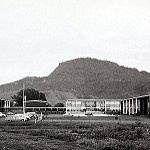

(Image size  = (150, 150, 3) ; Images = forest)


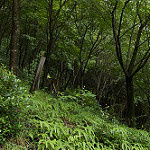

(Image size  = (150, 150, 3) ; Images = glacier)


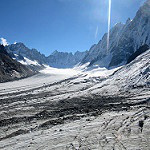

(Image size  = (150, 150, 3) ; Images = mountain)


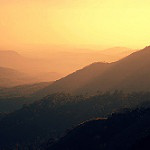

(Image size  = (150, 150, 3) ; Images = sea)


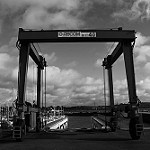

(Image size  = (150, 150, 3) ; Images = street)


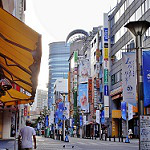

In [7]:
# display sample images of dataset

# set seed
SEED = 623
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
np.random.seed(SEED)
tf.random.set_seed(SEED)

# display images
for i in range(len(labels)):
    image_file = list(train_dir.glob(labels[i]+'/*'))
    img = PIL.Image.open(str(image_file[0]))
    
    print(f'(Image size  = ({img.size[0]}, {img.size[0]}, {len(img.mode)}) ; Images = {labels[i]})')
    display(img)

## 2: Baseline CNN Model

First, the data is split into training and testing datasets. A baseline CNN model for image classification is then built, trained, and evaluated.

In [8]:
# set params
batch_size = 64
t_t_s = 0.8
image_height = 150
image_width = 150

# create training df
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'int',
    validation_split = t_t_s,
    subset = "training",
    seed = SEED,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 14034 files belonging to 6 classes.
Using 2807 files for training.


In [9]:
# create validation df
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels = 'inferred',
    label_mode = 'int',
    validation_split = (1 - t_t_s),
    subset = "validation",
    seed = SEED,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 3000 files belonging to 6 classes.
Using 599 files for validation.


In [10]:
# get # of labels and channels
num_labels = len(labels)
print(f'There are {num_labels} classes in the image dataset')
image_channel = 3
print(f' There are {image_channel} channels in the images')

# build model
model1 = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (image_height, image_width, image_channel)),
    
    # first convolution layer
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    # pooling window
    layers.MaxPooling2D(),
  
    # second convolution layer
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    # pooling window
    layers.MaxPooling2D(),
  
    #third convolution layer
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    # pooling window
    layers.MaxPooling2D(),

    # flatten
    layers.Flatten(),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(num_labels)
])

There are 6 classes in the image dataset
 There are 3 channels in the images


In [11]:
# look at model structure
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

In [12]:
# configure model
model1.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [13]:
# create callback
cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3)

# set # of epochs
epochs = 15

In [14]:
%%time

# fit model
CNN_baseline = model1.fit(
    train_data,
    validation_data = val_data,
    epochs = epochs,
    callbacks = [cb], 
    verbose = 1
)

Epoch 1/15
44/44 [==============================] - 40s 856ms/step - loss: 1.3709 - accuracy: 0.4564 - val_loss: 1.0665 - val_accuracy: 0.5826
Epoch 2/15
44/44 [==============================] - 35s 773ms/step - loss: 0.9757 - accuracy: 0.6377 - val_loss: 0.9712 - val_accuracy: 0.6311
Epoch 3/15
44/44 [==============================] - 33s 746ms/step - loss: 0.8301 - accuracy: 0.6836 - val_loss: 0.9319 - val_accuracy: 0.6578
Epoch 4/15
44/44 [==============================] - 33s 750ms/step - loss: 0.6794 - accuracy: 0.7567 - val_loss: 0.8479 - val_accuracy: 0.7028
Epoch 5/15
44/44 [==============================] - 34s 758ms/step - loss: 0.5773 - accuracy: 0.7870 - val_loss: 0.7827 - val_accuracy: 0.7262
Epoch 6/15
44/44 [==============================] - 34s 763ms/step - loss: 0.4655 - accuracy: 0.8372 - val_loss: 0.8990 - val_accuracy: 0.6778
Epoch 7/15
44/44 [==============================] - 34s 772ms/step - loss: 0.3931 - accuracy: 0.8700 - val_loss: 0.7866 - val_accuracy: 0.7212

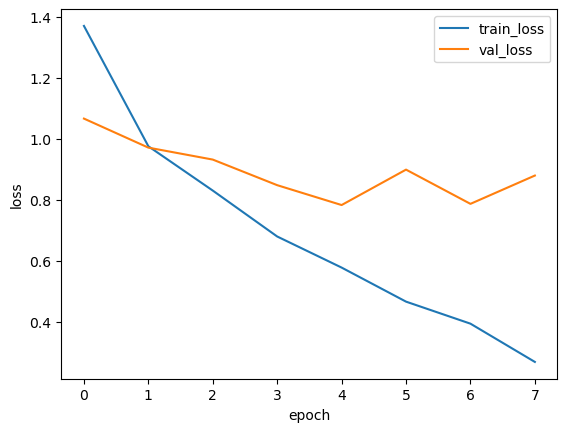

In [15]:
train_history1 = pd.DataFrame(CNN_baseline.history)
train_history1['epoch'] = CNN_baseline.epoch

# plot train loss and validation loss
sns.lineplot(x = 'epoch', y = 'loss', data = train_history1)
sns.lineplot(x = 'epoch', y = 'val_loss', data = train_history1)
# add legends
plt.legend(labels = ['train_loss', 'val_loss'])

The first CNN model is overfit.

Training loss starts at about 1.4 and continually decreases with a negative slope to around 0.1.

Validation loss starts lower than training loss, near 1.1. It decreases with a negative slope for epochs 1 through 3, but the slope becomes positive at epochs 5 and 6. Validation loss is above training loss after epoch 1.

The decreasing training loss and higher, increasing validation loss indicates that the baseline CNN model is overfitting.

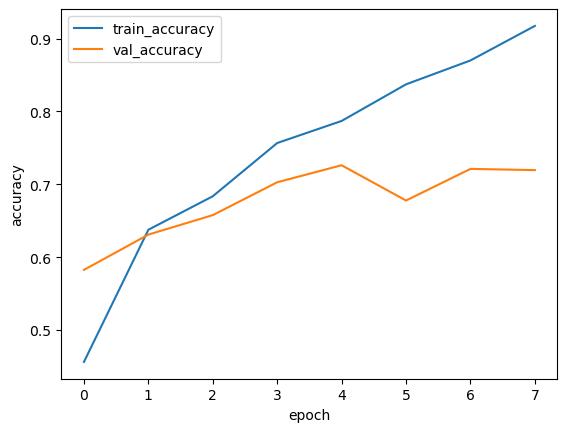

In [16]:
# plot train accuracy and validation accuracy
sns.lineplot(x = 'epoch', y = 'accuracy', data = train_history1)
sns.lineplot(x = 'epoch', y = 'val_accuracy', data = train_history1)
# add legends
plt.legend(labels = ['train_accuracy', 'val_accuracy'])

The validation accuracy and training accuracy curve also point to the model being overfit.

Training accuracy starts around 0.1. It continually increases with a positive slope. Validation accuracy starts higher than training accuracy, at around 0.6, but it stays lower than training accuracy for the remaining epochs.

Training accuracy being ultimately higher than validation accuracy, and diverging from it, confirms that the model is overfit.

In [17]:
test_loss1, test_acc1 = model1.evaluate(val_data, verbose = 0)
print(f' The test loss = {test_loss1:.2f} and test accuracy = {test_acc1:.2f}')

 The test loss = 0.88 and test accuracy = 0.72


## 3: Second CNN Model
The baseline CNN model is rebuilt with the addition of data augmentation and dropout. It is then evaluated.

In [18]:
# transform images
data_aug = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape = (image_height, 
                                                              image_width,
                                                              image_channel)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor = 0.1,width_factor = 0.1 ),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (0.1, 0.1))
  ]
)

In [19]:
# build model w/ data aug
model2 = tf.keras.Sequential([
    # data augmentation
    data_aug,
    
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (image_height, image_width, image_channel)),
    
    # first convolution layer
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    # pooling window
    layers.MaxPooling2D(),
  
    # second convolution layer
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    # pooling window
    layers.MaxPooling2D(),
  
    # third convolution layer
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    # pooling window
    layers.MaxPooling2D(),
    
    # flatten
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    # dropout layer
    layers.Dropout(0.2),
    layers.Dense(num_labels)
])

In [20]:
# configure model
model2.compile(optimizer = 'adam',
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
               metrics = ['accuracy'])

In [21]:
# look at model structure
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

In [22]:
%%time

# train model
CNN_data_aug = model2.fit(
    train_data,
    validation_data = val_data,
    epochs = epochs,
    callbacks = [cb],
    verbose = 1
)

Epoch 1/15
44/44 [==============================] - 43s 940ms/step - loss: 1.4733 - accuracy: 0.3954 - val_loss: 1.3821 - val_accuracy: 0.4608
Epoch 2/15
44/44 [==============================] - 42s 943ms/step - loss: 1.1818 - accuracy: 0.5233 - val_loss: 1.2328 - val_accuracy: 0.5259
Epoch 3/15
44/44 [==============================] - 44s 996ms/step - loss: 1.1182 - accuracy: 0.5643 - val_loss: 1.2985 - val_accuracy: 0.5643
Epoch 4/15
44/44 [==============================] - 40s 914ms/step - loss: 1.0416 - accuracy: 0.5953 - val_loss: 1.2224 - val_accuracy: 0.5826
Epoch 5/15
44/44 [==============================] - 40s 914ms/step - loss: 1.0230 - accuracy: 0.6006 - val_loss: 1.1560 - val_accuracy: 0.5893
Epoch 6/15
44/44 [==============================] - 41s 932ms/step - loss: 0.9954 - accuracy: 0.6192 - val_loss: 1.2637 - val_accuracy: 0.5960
Epoch 7/15
44/44 [==============================] - 41s 925ms/step - loss: 0.9601 - accuracy: 0.6313 - val_loss: 1.2857 - val_accuracy: 0.5910

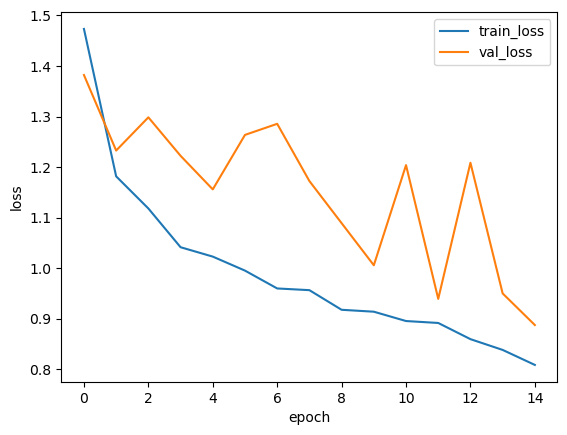

In [23]:
train_history2 = pd.DataFrame(CNN_data_aug.history)
train_history2['epoch'] = CNN_data_aug.epoch

# plot train loss and validation loss
sns.lineplot(x = 'epoch', y = 'loss', data = train_history2)
sns.lineplot(x = 'epoch', y = 'val_loss', data = train_history2)
# add legends
plt.legend(labels = ['train_loss', 'val_loss'])

The training loss and validation loss curve for the second CNN shows a better fit than the first model, but could be improved.

Training loss starts at around 1.5 and decreases after 1 epoch to around 1.2. It then continuously decreases with a negative slope.

Validation loss starts lower than training loss, at about 1.4. It continually decreases, but crosses above training loss at epoch 1. 

The decreasing training loss and higher validation loss indicates that there is room for improvement in the model.

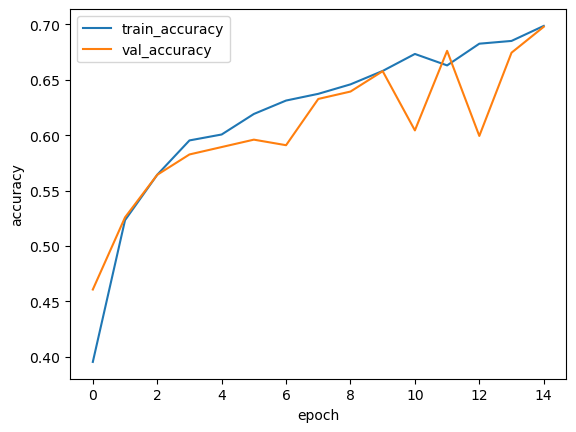

In [24]:
# plot train accuracy and validation accuracy
sns.lineplot(x = 'epoch', y = 'accuracy', data = train_history2)
sns.lineplot(x = 'epoch', y = 'val_accuracy', data = train_history2)
# add legends
plt.legend(labels = ['train_accuracy', 'val_accuracy'])

The training accuracy and validation accuracy curve is significantly better than that of the first CNN model. 

Training accuracy starts near 0.4. It sharply increases at epoch 1 to about 0.525 and continues to increase. Validation accuracy starts higher than training accuracy at around 0.46. It then crosses below training accuracy at epoch 2 and remains below, but close, to training accuracy.

In [25]:
test_loss2, test_acc2 = model2.evaluate(val_data, verbose = 0)
print(f' The test loss = {test_loss2:.2f} and test accuracy = {test_acc2:.2f}')

 The test loss = 0.89 and test accuracy = 0.70


The second convolutional neural network does not perform better than the first model, but it is a better fit. The test loss is slightly higher and the test accuracy is .02 below the first model's.



## 4: Third CNN Model
A third CNN model is built based on a pre-trained model. It is then evaluated.

In [26]:
# specify image size
IMG_SHAPE = (image_height, image_width, image_channel)

# pretrain on image net
MobileNetV3Large_model = tf.keras.applications.MobileNetV3Large(input_shape = IMG_SHAPE,
                                                                include_top = False,
                                                                weights = 'imagenet')

In [27]:
# freeze top layer
MobileNetV3Large_model.trainable = False

In [28]:
# preprocess data
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

# take a batch
image_batch, label_batch = next(iter(train_data))
feature_batch = MobileNetV3Large_model(image_batch)
# check size
print(feature_batch.shape)

# convert from 2D to 4D
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# flatten
global_average_layer = tf.keras.layers.Flatten()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 5, 5, 960)
(64, 960)
(64, 24000)


In [29]:
# add classification layer
prediction_layer = tf.keras.layers.Dense(6)
prediction_batch = prediction_layer(feature_batch_average)
print(f' The size of the predicted value for a given batch = {prediction_batch.shape}')

 The size of the predicted value for a given batch = (64, 6)


In [30]:
# create model
inputs = tf.keras.Input(shape = IMG_SHAPE)

x = data_aug(inputs)
x = preprocess_input(x)
x = MobileNetV3Large_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model3 = tf.keras.Model(inputs, outputs)

In [31]:
# set learning rate
learning_rate = 0.0001

# configure model
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
               metrics = ['accuracy'])

In [32]:
# look at model structure
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 5, 5, 960)        2996352   
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 24000)             0         
                                                                 
 dropout_1 (Dropout)         (None, 24000)             0         
                                                                 
 dense_4 (Dense)             (None, 6)                 144006    
                                                             

In [33]:
%%time

# train model
CNN_pretrained = model3.fit(
    train_data,
    validation_data = val_data,
    epochs = epochs,
    callbacks = [cb],
    verbose = 1
)

Epoch 1/15
44/44 [==============================] - 58s 1s/step - loss: 1.9854 - accuracy: 0.4955 - val_loss: 0.8717 - val_accuracy: 0.7245
Epoch 2/15
44/44 [==============================] - 48s 1s/step - loss: 1.0300 - accuracy: 0.7100 - val_loss: 0.7204 - val_accuracy: 0.7780
Epoch 3/15
44/44 [==============================] - 56s 1s/step - loss: 0.9213 - accuracy: 0.7453 - val_loss: 0.6061 - val_accuracy: 0.8147
Epoch 4/15
44/44 [==============================] - 51s 1s/step - loss: 0.7517 - accuracy: 0.7830 - val_loss: 0.6490 - val_accuracy: 0.8114
Epoch 5/15
44/44 [==============================] - 46s 1s/step - loss: 0.7140 - accuracy: 0.7941 - val_loss: 0.5950 - val_accuracy: 0.8297
Epoch 6/15
44/44 [==============================] - 46s 1s/step - loss: 0.7180 - accuracy: 0.8098 - val_loss: 0.5700 - val_accuracy: 0.8447
Epoch 7/15
44/44 [==============================] - 45s 1s/step - loss: 0.6050 - accuracy: 0.8197 - val_loss: 0.5531 - val_accuracy: 0.8514
Epoch 8/15
44/44 [==

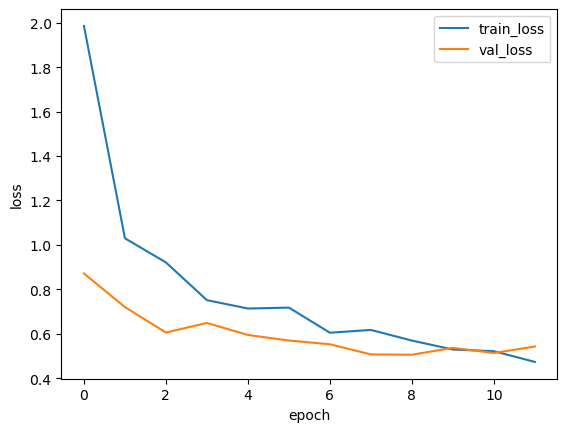

In [34]:
train_history3 = pd.DataFrame(CNN_pretrained.history)
train_history3['epoch'] = CNN_pretrained.epoch

# plot train loss and validation loss
sns.lineplot(x = 'epoch', y = 'loss', data = train_history3)
sns.lineplot(x = 'epoch', y = 'val_loss', data = train_history3)
# add legends
plt.legend(labels = ['train_loss', 'val_loss'])

The third CNN is slightly overfit but decent. It is an improvement upon the first two models.

Training loss starts near 2. It then sharply decreases to 1 at epoch 1 and continues to decrease with a negative slope.

Validation loss starts much lower than training loss, just below 0.8. It slowly decreases and plateaus at epoch 3 and beyond. The validation loss slightly crosses over training loss at epoch 10.

The decreasing training loss and validation loss indicates that the third CNN is slightly overfit, but decent.

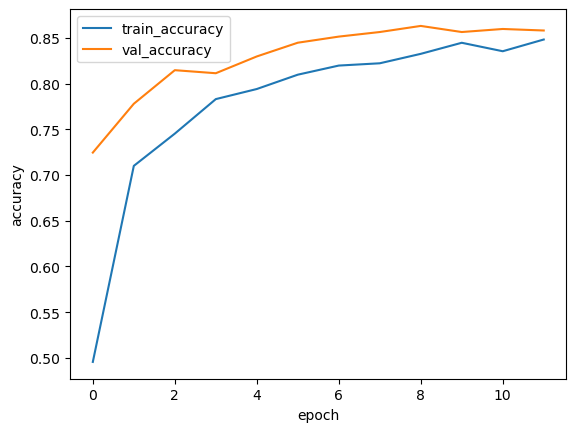

In [76]:
# plot train accuracy and validation accuracy
sns.lineplot(x = 'epoch', y = 'accuracy', data = train_history3)
sns.lineplot(x = 'epoch', y = 'val_accuracy', data = train_history3)
# add legends
plt.legend(labels = ['train_accuracy', 'val_accuracy'])

The training accuracy and validation accuracy curve echoes the loss curve. 

Training accuracy starts at around 0.50 and sharply increases to 0.7 at epoch 1. It then continually increases for the remaining epochs.

Validation accuracy starts above training accuracy around 0.725 and increases steadily with a positive slope. It remains above, but close, to the training accuracy.

The higher validation accuracy and steadily increasing training accuracy indicate that the model is a decent fit.

In [36]:
test_loss3, test_acc3 = model3.evaluate(val_data, verbose = 0)
print(f' The test loss = {test_loss3:.2f} and test accuracy = {test_acc3:.2f}')

 The test loss = 0.54 and test accuracy = 0.86


## 5: Recommendation
The three CNN models are compared.

In [37]:
print(f' Model 1 test loss = {test_loss1:.2f} and test accuracy = {test_acc1:.2f}')
print(f' Model 2 test loss = {test_loss2:.2f} and test accuracy = {test_acc2:.2f}')
print(f' Model 3 test loss = {test_loss3:.2f} and test accuracy = {test_acc3:.2f}')

 Model 1 test loss = 0.88 and test accuracy = 0.72
 Model 2 test loss = 0.89 and test accuracy = 0.70
 Model 3 test loss = 0.54 and test accuracy = 0.86


The **third CNN model**, which utilized a pre-trained model, is by far the best performing model of the three. It has the lowest test loss and the highest test accuracy. This indicates that it makes the smallest and fewest errors out of the three models.

The test loss is 0.34 lower than the other two models. Test accuracy is 0.86, significantly higher than that of the other two models.

Having the lowest test loss means that this model has the smallest distance between the real values and the predicted values. It makes the smallest errors out of the three models.

The highest test accuracy means that the third model makes the fewest errors out of all the models. The images are classified correctly 86% of the time.

# Part II: Sentiment Analysis

Three RNN models are developed to perform sentiment analysis on a restaurant review dataset.

Data Source: https://www.kaggle.com/datasets/hj5992/restaurantreviews


## 1: Loading the data
The dataset is downloaded from Kaggle into the local disk and unzipped.

In [38]:
# download dataset from kaggle
#!kaggle datasets download -d hj5992/restaurantreviews

In [39]:
review_dir =  "C:\\Users\\laure\\Documents\\School\\DSCI 419 - Deep Learning\\restaurantreviews"

# extract zip file
with ZipFile("C:\\Users\\laure\\Documents\\School\\DSCI 419 - Deep Learning\\restaurantreviews.zip") as zip_file:
    for member in zip_file.namelist():
        if os.path.exists(review_dir + r'\\' + member) or os.path.isfile(review_dir + r'\\' + member):
            print('Error: ', member, ' exists.')
        else:
            zip_file.extract(member, review_dir)
    
# output directory
print(f'The data is stored in local directory : {review_dir}')

# convert 
review_dir = pathlib.Path(review_dir)

Error:  Restaurant_Reviews.tsv  exists.
The data is stored in local directory : C:\Users\laure\Documents\School\DSCI 419 - Deep Learning\restaurantreviews


In [40]:
# get file path
file_path = 'C:\\Users\\laure\\Documents\\School\\DSCI 419 - Deep Learning\\restaurantreviews\\Restaurant_Reviews.tsv'

# read in csv
reviews = pd.read_csv(file_path, sep = '\t')

In [41]:
# look at first few rows
reviews.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [42]:
# check missing values
reviews.isnull().sum(axis = 0)

Review    0
Liked     0
dtype: int64

In [43]:
# check datatypes
reviews.dtypes

Review    object
Liked      int64
dtype: object

In [44]:
# convert review col to string
reviews['Review'] = reviews['Review'].astype(str)

## 2: Clean and preprocess text data. Split into training and testing datasets.
The data is cleaned with regular expressions. Then the data is split into training and testing datasets. The text data is then preprocessed to numeric format.

In [45]:
# remove all special characters and punctuation
reviews['Review'] = reviews['Review'].apply(lambda x: re.sub(r'[^A-Za-z0-9]', ' ', x))

# replace <br />
reviews['Review'] = reviews['Review'].apply(lambda x: re.sub(r'<br />', ' ', x))

# remove length <= 2
reviews['Review'] = reviews['Review'].apply(lambda x: re.sub(r'\b[a-zA-Z]{1,2}\b', ' ', x))

# remove extra spaces
reviews['Review'] = reviews['Review'].apply(lambda x: re.sub(r'\s+', ' ', x))

reviews['Review'] = reviews['Review'].str.rstrip()

# check first few output
reviews.head()

,Review,Liked
0,Wow Loved this place,1
1,Crust not good,0
2,Not tasty and the texture was just nasty,0
3,Stopped during the late May bank holiday off R...,1
4,The selection the menu was great and were the ...,1


In [46]:
# get features and labels
X = reviews['Review'].values
y = reviews['Liked'].values

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 25)

In [125]:
# specify vocab size
VOCAB_SIZE = 500

# convert text to numeric
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens = VOCAB_SIZE)

# fit state of preprocessing layer to df
encoder.adapt(X_train)

## 3: Baseline RNN
A baseline RNN model is built using an embedding layer and GRU. It is then evaluated.

In [126]:
# set params
learning_rate2 = .01
batch_size2 = 32
epochs2 = 8

In [127]:
# build model
modelA = tf.keras.Sequential([
    # convert review text to indices
    encoder,
    
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        # use masking to handle variable sequence lengths
        mask_zero = True),

    # GRU layer
    tf.keras.layers.GRU(128),

    # classifier layer
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

In [128]:
# configure model
modelA.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
               optimizer = tf.keras.optimizers.Adam(learning_rate2),
               metrics = ['accuracy'])

In [129]:
# look at model structure
modelA.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_8 (Embedding)     (None, None, 32)          16000     
                                                                 
 gru_5 (GRU)                 (None, 128)               62208     
                                                                 
 dense_21 (Dense)            (None, 16)                2064      
                                                                 
 dense_22 (Dense)            (None, 1)                 17        
                                                                 
Total params: 80,289
Trainable params: 80,289
Non-trainable params: 0
_________________________________________________

In [130]:
%%time

# train model
RNN_baseline = modelA.fit(x = X_train,
                          y = y_train,
                          batch_size = batch_size2,
                          epochs = epochs2,
                          validation_data = (X_test, y_test),
                          verbose = 1
                         )

Epoch 1/8
25/25 [==============================] - 7s 133ms/step - loss: 0.6679 - accuracy: 0.5500 - val_loss: 0.5995 - val_accuracy: 0.7350
Epoch 2/8
25/25 [==============================] - 2s 87ms/step - loss: 0.4188 - accuracy: 0.8363 - val_loss: 0.5292 - val_accuracy: 0.7200
Epoch 3/8
25/25 [==============================] - 2s 88ms/step - loss: 0.2473 - accuracy: 0.8875 - val_loss: 0.5214 - val_accuracy: 0.7900
Epoch 4/8
25/25 [==============================] - 2s 88ms/step - loss: 0.1765 - accuracy: 0.9212 - val_loss: 0.4437 - val_accuracy: 0.8050
Epoch 5/8
25/25 [==============================] - 2s 87ms/step - loss: 0.1114 - accuracy: 0.9538 - val_loss: 0.5040 - val_accuracy: 0.8300
Epoch 6/8
25/25 [==============================] - 2s 87ms/step - loss: 0.1028 - accuracy: 0.9550 - val_loss: 0.5286 - val_accuracy: 0.8500
Epoch 7/8
25/25 [==============================] - 2s 86ms/step - loss: 0.0691 - accuracy: 0.9675 - val_loss: 0.5542 - val_accuracy: 0.8400
Epoch 8/8
25/25 [==

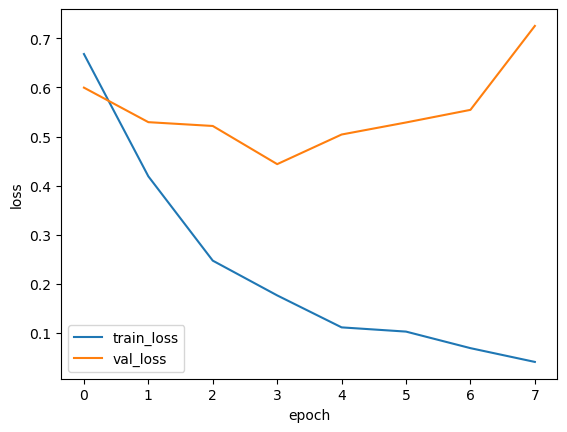

In [131]:
train_historyA = pd.DataFrame(RNN_baseline.history)
train_historyA['epoch'] = RNN_baseline.epoch

# plot train and validation loss
sns.lineplot(x = 'epoch', y = 'loss', data = train_historyA)
sns.lineplot(x = 'epoch', y = 'val_loss', data = train_historyA)

# add legend
plt.legend(labels = ['train_loss', 'val_loss'])

The training loss and validation loss of the first RNN model indicate that it is overfit. 

Training loss starts at around 0.7 and steadily decreases with a negative slope.

Validation loss starts not much lower than training loss, near 0.6. It crosses over training loss before epoch 1 and begins increasing with a positive slope.

The decreasing training loss and higher, increasing validation loss indicate that the model is overfit.

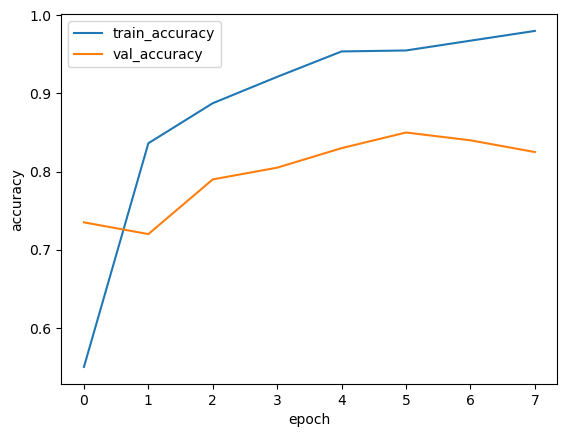

In [132]:
# plot train and validation accuracy
sns.lineplot(x = 'epoch', y = 'accuracy', data = train_historyA)
sns.lineplot(x = 'epoch', y = 'val_accuracy', data = train_historyA)

# Add legends
plt.legend(labels = ['train_accuracy', 'val_accuracy'])

The training accuracy and validation accuracy quickly diverge.

Training accuracy starts at around 0.5 and increases sharply at epoch 1 to 0.85. It then increases with a positive slope.

Validation accuracy starts near 0.75 and stays around 0.8 for the remaining epochs.

In [133]:
# forecast
y_predA = (modelA.predict(X_test) > 0.5).astype(int)

7/7 [==============================] - 1s 17ms/step


In [134]:
# get confusion matrix labels
tn, fp, fn, tp = confusion_matrix(y_test, y_predA).ravel()
print(tn, fp, fn, tp)

77 23 12 88


In [135]:
# get classification report
label_names = ['negative', 'positive']
RNN_baseline_cr = classification_report(y_test, y_predA, target_names = label_names)
print(RNN_baseline_cr)

              precision    recall  f1-score   support

    negative       0.87      0.77      0.81       100
    positive       0.79      0.88      0.83       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200



The first RNN model has room for improvement. The overall accuracy is smaller than 85%, coming in at 82%. The f1-score for positives and negatives are also lower than 85%, at 81 and 83%. This means that the model correctly classifies reviews on average 82% of the time. This can be improved.

## 4: Second RNN model
A second RNN model is built with an embedding layer and LSTM, and then evaluated.

In [136]:
# build model
modelB = tf.keras.Sequential([
    # convert review text to indices
    encoder,
    
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        # use masking to handle variable sequence lengths
        mask_zero = True),

    # LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    
    # classifier layer
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

In [137]:
# configure model
modelB.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
               optimizer = tf.keras.optimizers.Adam(learning_rate2),
               metrics = ['accuracy'])

In [138]:
# look at model structure
modelB.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_9 (Embedding)     (None, None, 32)          16000     
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dense_23 (Dense)            (None, 16)                4112      
                                                                 
 dense_24 (Dense)            (None, 1)                 17        
                                                                 
Total params: 184,993
Trainable params: 184,993
Non-t

In [139]:
%%time

# train model
RNN_LSTM = modelB.fit(x = X_train,
                      y = y_train,
                      batch_size = batch_size2,
                      epochs = epochs2,
                      validation_data = (X_test, y_test),
                      verbose = 1
                     )

Epoch 1/8
25/25 [==============================] - 14s 296ms/step - loss: 0.6292 - accuracy: 0.6250 - val_loss: 0.4931 - val_accuracy: 0.7750
Epoch 2/8
25/25 [==============================] - 5s 200ms/step - loss: 0.4131 - accuracy: 0.8413 - val_loss: 0.4942 - val_accuracy: 0.7350
Epoch 3/8
25/25 [==============================] - 5s 216ms/step - loss: 0.2647 - accuracy: 0.8788 - val_loss: 0.4893 - val_accuracy: 0.7750
Epoch 4/8
25/25 [==============================] - 5s 209ms/step - loss: 0.2083 - accuracy: 0.9075 - val_loss: 0.4661 - val_accuracy: 0.8200
Epoch 5/8
25/25 [==============================] - 5s 215ms/step - loss: 0.1560 - accuracy: 0.9362 - val_loss: 0.4957 - val_accuracy: 0.7950
Epoch 6/8
25/25 [==============================] - 6s 224ms/step - loss: 0.1325 - accuracy: 0.9513 - val_loss: 0.5862 - val_accuracy: 0.8200
Epoch 7/8
25/25 [==============================] - 6s 229ms/step - loss: 0.0983 - accuracy: 0.9613 - val_loss: 0.7258 - val_accuracy: 0.8000
Epoch 8/8
25

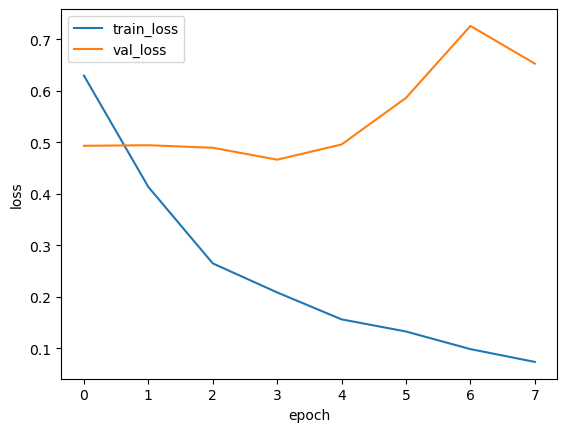

In [140]:
train_historyB = pd.DataFrame(RNN_LSTM.history)
train_historyB['epoch'] = RNN_LSTM.epoch

# plot train and validation loss
sns.lineplot(x = 'epoch', y = 'loss', data = train_historyB)
sns.lineplot(x = 'epoch', y = 'val_loss', data = train_historyB)

# add legend
plt.legend(labels = ['train_loss', 'val_loss'])

The training loss and validation loss curve point to the second RNN model being overfit.

Training loss starts around 0.7 and steadily decreases with a negative slope.

Validation loss starts below training loss at around 0.5. It decreases initially, but increases with a positive slope after epoch 1. 

The decreasing training loss and higher, increasing validation loss indicate that the model is overfit.

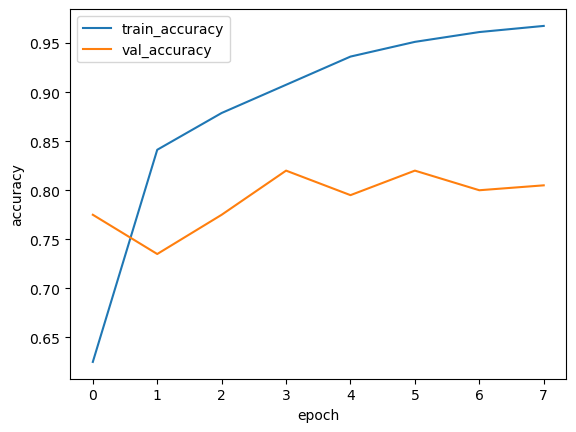

In [141]:
# plot train and validation accuracy
sns.lineplot(x = 'epoch', y = 'accuracy', data = train_historyB)
sns.lineplot(x = 'epoch', y = 'val_accuracy', data = train_historyB)

# add legend
plt.legend(labels = ['train_accuracy', 'val_accuracy'])

Decreasing and diverging validation accuracy indicate that the model could be improved. 

Training accuracy starts around 0.6 and increases with a positive slope. Validation accuracy starts above training accuracy at around 0.775. It initially decreases until epoch 1. It then begins increasing.

In [142]:
# forecast
y_predB = (modelB.predict(X_test) > 0.5).astype(int)

7/7 [==============================] - 3s 44ms/step


In [143]:
# get confusion matrix labels
tn, fp, fn, tp = confusion_matrix(y_test, y_predB).ravel()
print(tn, fp, fn, tp)

87 13 26 74


In [144]:
# get classification report
RNN_LSTM_cr = classification_report(y_test, y_predB, target_names = label_names)
print(RNN_LSTM_cr)

              precision    recall  f1-score   support

    negative       0.77      0.87      0.82       100
    positive       0.85      0.74      0.79       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200



The accuracy and f1-score of the second RNN model are not an improvement upon the first model. 

The accuracy is 0.81, which is lower than 85%. The f1-score is also lower than 85%, coming in at 82% for negatives and 79% for positives. This can be improved.

## 5: Third RNN Model
An embedding layer, GRU, and LSTM are used to build a third model. It is then evaluated.

In [145]:
# build model
modelC = tf.keras.Sequential([
    # convert review text to indices
    encoder,
    
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        # use masking to handle variable sequence lengths
        mask_zero = True),

    # GRU layer
    tf.keras.layers.GRU(128, return_sequences = True),
    
    # LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    
    # classifier layer
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

In [146]:
# look at model structure
modelC.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_10 (Embedding)    (None, None, 32)          16000     
                                                                 
 gru_6 (GRU)                 (None, None, 128)         62208     
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_25 (Dense)            (None, 16)                4112      
                                                                 
 dense_26 (Dense)            (None, 1)               

In [147]:
# configure model
modelC.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
               optimizer = tf.keras.optimizers.Adam(learning_rate2),
               metrics = ['accuracy'])

In [148]:
%%time

# train model
RNN_GRU_LSTM = modelC.fit(x = X_train,
                          y = y_train,
                          batch_size = batch_size2,
                          epochs = epochs2,
                          validation_data = (X_test, y_test),
                          verbose = 1
                         )

Epoch 1/8
25/25 [==============================] - 27s 705ms/step - loss: 0.6787 - accuracy: 0.5962 - val_loss: 0.6457 - val_accuracy: 0.6750
Epoch 2/8
25/25 [==============================] - 14s 542ms/step - loss: 0.4249 - accuracy: 0.8138 - val_loss: 0.4883 - val_accuracy: 0.7250
Epoch 3/8
25/25 [==============================] - 14s 566ms/step - loss: 0.2766 - accuracy: 0.8913 - val_loss: 0.4988 - val_accuracy: 0.8100
Epoch 4/8
25/25 [==============================] - 15s 585ms/step - loss: 0.1917 - accuracy: 0.9337 - val_loss: 0.4144 - val_accuracy: 0.8100
Epoch 5/8
25/25 [==============================] - 15s 577ms/step - loss: 0.1467 - accuracy: 0.9488 - val_loss: 0.5206 - val_accuracy: 0.8000
Epoch 6/8
25/25 [==============================] - 15s 585ms/step - loss: 0.1581 - accuracy: 0.9413 - val_loss: 0.4466 - val_accuracy: 0.7900
Epoch 7/8
25/25 [==============================] - 15s 593ms/step - loss: 0.1184 - accuracy: 0.9538 - val_loss: 0.4947 - val_accuracy: 0.8200
Epoch 

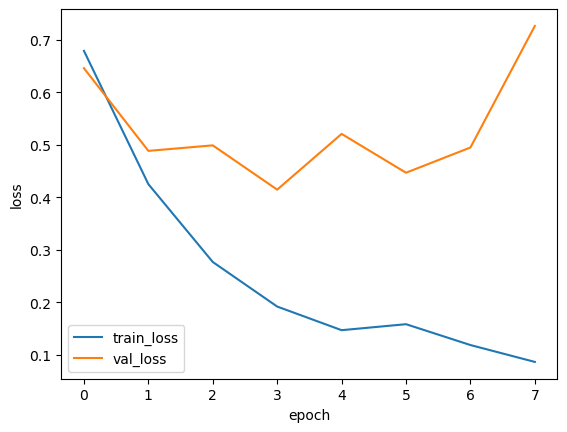

In [149]:
train_historyC = pd.DataFrame(RNN_GRU_LSTM.history)
train_historyC['epoch'] = RNN_GRU_LSTM.epoch

# plot train and validation loss
sns.lineplot(x = 'epoch', y = 'loss', data = train_historyC)
sns.lineplot(x = 'epoch', y = 'val_loss', data = train_historyC)

# add legend
plt.legend(labels = ['train_loss', 'val_loss'])

The third RNN model is overfit. 

Training loss starts just below 0.7. It sharply decreases with a negative slope. 

Validation loss starts around 0.65. It initially decreases up until epoch 5. Then it increases with a positive slope.

The decreasing training loss and the higher validation loss indicate that the model is overfit.

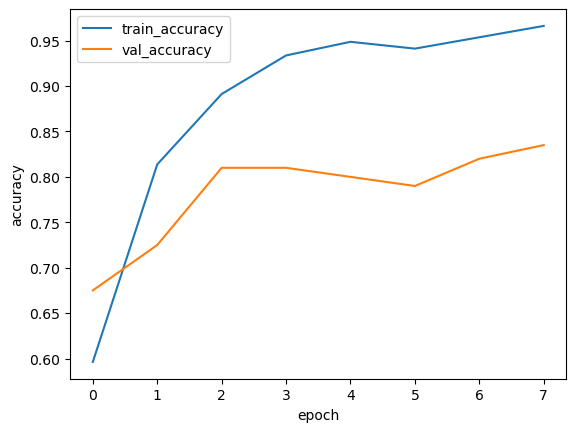

In [150]:
# plot train and validation accuracy
sns.lineplot(x = 'epoch', y = 'accuracy', data = train_historyC)
sns.lineplot(x = 'epoch', y = 'val_accuracy', data = train_historyC)

# add legend
plt.legend(labels = ['train_accuracy', 'val_accuracy'])

Training accuracy quickly becomes much higher than validation accuracy, pointing to the model be overfit. 

Training accuracy starts at 0.6 and increases with a positive slope. Validation accuracy starts higher than training accuracy at around 0.675. It continues increasing, but falls below training accuracy.

In [151]:
# forecast
y_predC = (modelC.predict(X_test) > 0.5).astype(int)

7/7 [==============================] - 4s 108ms/step


In [152]:
# get confusion matrix labels
tn, fp, fn, tp = confusion_matrix(y_test, y_predC).ravel()
print(tn, fp, fn, tp)

80 20 13 87


In [153]:
# get classification report
RNN_GRU_LSTM = classification_report(y_test, y_predC, target_names = label_names)
print(RNN_GRU_LSTM)

              precision    recall  f1-score   support

    negative       0.86      0.80      0.83       100
    positive       0.81      0.87      0.84       100

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.84      0.83      0.83       200



The third RNN model is an improvement upon the first two models. The f1-scores are higher than those of the previous models at 83% and 84%. These are still below the benchmark of 85%. The accuracy is also lower than 85%, coming in at 83%.

## 6: Recommendation
The three RNN models are compared.

In [154]:
print(f'1. BASELINE\n {RNN_baseline_cr}\n')
print(f'2. LSTM ONLY\n {RNN_LSTM_cr}\n')
print(f'3. LSTM + GRU\n {RNN_GRU_LSTM}')

1. BASELINE
               precision    recall  f1-score   support

    negative       0.87      0.77      0.81       100
    positive       0.79      0.88      0.83       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200


2. LSTM ONLY
               precision    recall  f1-score   support

    negative       0.77      0.87      0.82       100
    positive       0.85      0.74      0.79       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200


3. LSTM + GRU
               precision    recall  f1-score   support

    negative       0.86      0.80      0.83       100
    positive       0.81      0.87      0.84       100

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.84      0

The **third RNN model**, which uses both GRU and LSTM, performs the best out of the three models. However, this model could still use improvement. 

The third RNN model is the best because it has the highest accuracy, highest f1-scores, and is the least biased. The accuracy is 83%, which is higher than the accuracies of the other two models. This means that the model classifies reviews correctly 83% of the time. 

The f1-scores are also the highest out of the three models. Negatives have an f1-score of 0.83 and positives have an f1-score of 0.84. This means that negative reviews are classified correctly 83% of the time and positive reviews are classified correctly 84% of the time. 

While the third model is the best, the differences between the accuracies and f1-scores of the three models is relatively small. What makes the third RNN model stand out is that it is the least biased. The difference between f1-scores for positives and negatives is only 0.01. The other two models have greater differences between f1-scores, revealing that they tend to classify either positive or negatives correctly more frequently than the other class.

In the end, the best performing RNN model of the three has an accuracy below the benchmark of 85%, coming in at 83%. The third RNN model is decent but could use some improvement.